# Splitter tutorial

This notebook presents the possibilities of splitters. They will help to split the train and test data.
RePlay offers several classes:

* TimeSplitter
* RandomSplitter
* NewUsersSplitter
* ColdUserRandomSplitter
* TwoStageSplitter
* RatioSplitter
* LastNSplitter

Each of them provides its own capabilities for data split.

### Split data

To split the data, you must call the `.split()` method on the Splitter object

### Return

Splitters return `train` and `test` cached DataFrame to compute them once and re-use for models training, inference and metrics calculation.


In [ ]:
!pip install seaborn matplotlib

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from replay.preprocessing import LabelEncoder, LabelEncodingRule
from replay.utils.common import load_from_replay, save_to_replay

sns.set_theme(style="whitegrid", palette="muted")

## Get started

Download the dataset **MovieLens** and preprocess it with `LabelEncoder`.

`LabelEncoder` is similar to `DatasetLabelEncoder` except that `LabelEncoder` processes Pandas, Polars or Spark datasets when `DatasetLabelEncoder` processes `replay.data.Dataset`. 

In [2]:
ratings = pd.read_csv(
    "./data/ml1m_ratings.dat",
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"],
    engine="python",
)
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit="s")

In [3]:
ratings.head(5)

,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
encoder = LabelEncoder(
    [
        LabelEncodingRule("user_id"),
        LabelEncodingRule("item_id"),
    ]
)
ratings = encoder.fit_transform(ratings)

`LabelEncoder` can be saved in JSON format with `save_to_replay()` or `.save()` methods. Than it can be loaded with `load_from_replay()` or `.load()` methods.

Note that `save_to_replay()`and `load_from_replay()` are functions from utils while `.save()`, `.load()` are methods of the class.

In [7]:
save_to_replay(encoder, "./encoder")  # or encoder.save("./encoder")
loaded_encoder = load_from_replay("./encoder")  # or LabelEncoder.load("./encoder")

For examples, we will use the 20 users with biggest interactions history

In [8]:
top_users = (
    ratings.groupby("user_id")[["item_id"]]
    .count()
    .nlargest(n=20, columns=["item_id"])
    .index
)

In [9]:
log_limit_20 = ratings[ratings.user_id.isin(top_users)]

In [12]:
len(log_limit_20)

28229

Function for viewing `train`, `test` data

In [51]:
def show_train_test(train, test):
    plt.figure(figsize=(25, 12))
    train_plt = train
    train_plt["split"] = "train"
    test_plt = test
    test_plt["split"] = "test"
    pd_for_print = pd.concat((train_plt, test_plt), axis=0)
    pd_for_print["user_id"] = pd_for_print["user_id"].astype(str)
    sns.scatterplot(data=pd_for_print, x="timestamp", y="user_id", hue="split", s=8 * 8)
    plt.autoscale(enable=True, axis="x")
    plt.grid(False)
    plt.show()

In [83]:
def show_frames(
    frames, names
):
    plt.figure(figsize=(25, 12))
    for frame, name in zip(frames, names):
        frame["split"] = name
    pd_for_print = pd.concat(frames, axis=0)
    pd_for_print["user_id"] = pd_for_print["user_id"].astype(str)
    
    def pick_color(name: str) -> str:
        s = name.lower()
        if "target" in s.lower():
            return "#ff7f0e"   
        elif "train" in s.lower() and "test" in s.lower():
            return "#2ca02c"   # 
        elif "test" in s.lower():
            return "#9acd32"  
        elif "train" in s.lower():
            return "#1f77b4"   
        return "#6c757d"      

    hue_order = list(dict.fromkeys(names))
    palette = {name: pick_color(name) for name in hue_order}
    
    sns.scatterplot(data=pd_for_print, x="timestamp", y="user_id", hue="split", s=8 * 8, palette=palette, hue_order=hue_order)
    plt.autoscale(enable=True, axis="x")
    plt.grid(False)
    plt.show()

Function for printing stats of df

In [24]:
def get_df_info(df: pd.DataFrame):
    print(
        f"Total rows {len(df)}, unique users: {df.user_id.nunique()}, unique items: {df.item_id.nunique()}"
    )

## General parameters of splitters

All splitters has the following common parameters:
* `drop_cold_users` flag to drop cold (not presented in train part) users from test

* `drop_cold_items` flag to drop cold (not presented in train part) users from test

* `date_column` timestamp column name

* `query_column` query id column name

* `item_column` item id column name

## class TimeSplitter()

Split into train and test by date.

#### Parameters other than gneral

* `test_start` string "yyyy-mm-dd" , int unix timestamp, datetime or a fraction for test size to determine the date automatically


In this example `test_start` parameter will take fraction for test size

In [25]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold=0.05,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column="user_id",
)

In [26]:
train, test = date_splitter.split(log_limit_20)

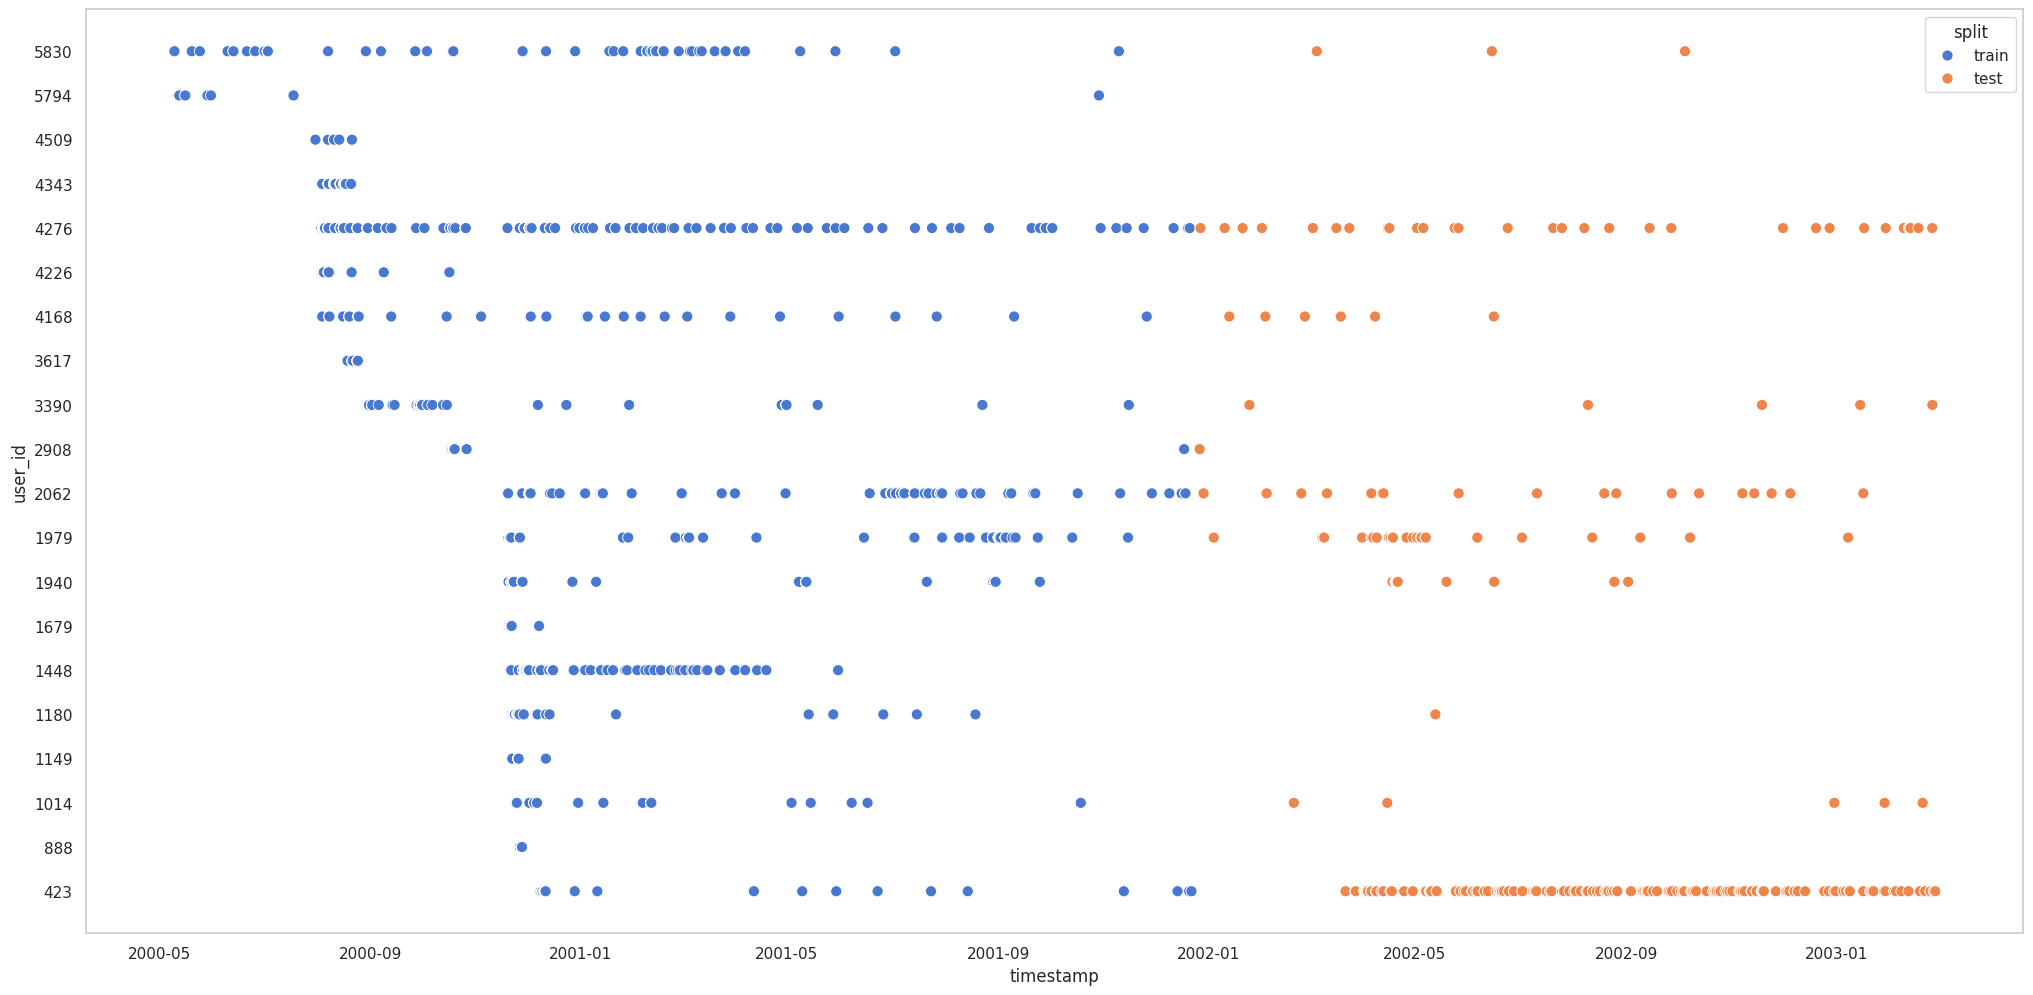

In [27]:
show_train_test(train, test)

In [28]:
get_df_info(train)

Total rows 26816, unique users: 20, unique items: 3303


In [29]:
get_df_info(test)

Total rows 1387, unique users: 11, unique items: 1152


In this example `test_start` parameter will take string "yyyy-mm-dd"

In [35]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold="2001-09",
    drop_cold_users=True,
    drop_cold_items=True,
    time_column_format="%Y-%m",
    query_column="user_id",
)

In [36]:
train, test = date_splitter.split(log_limit_20)

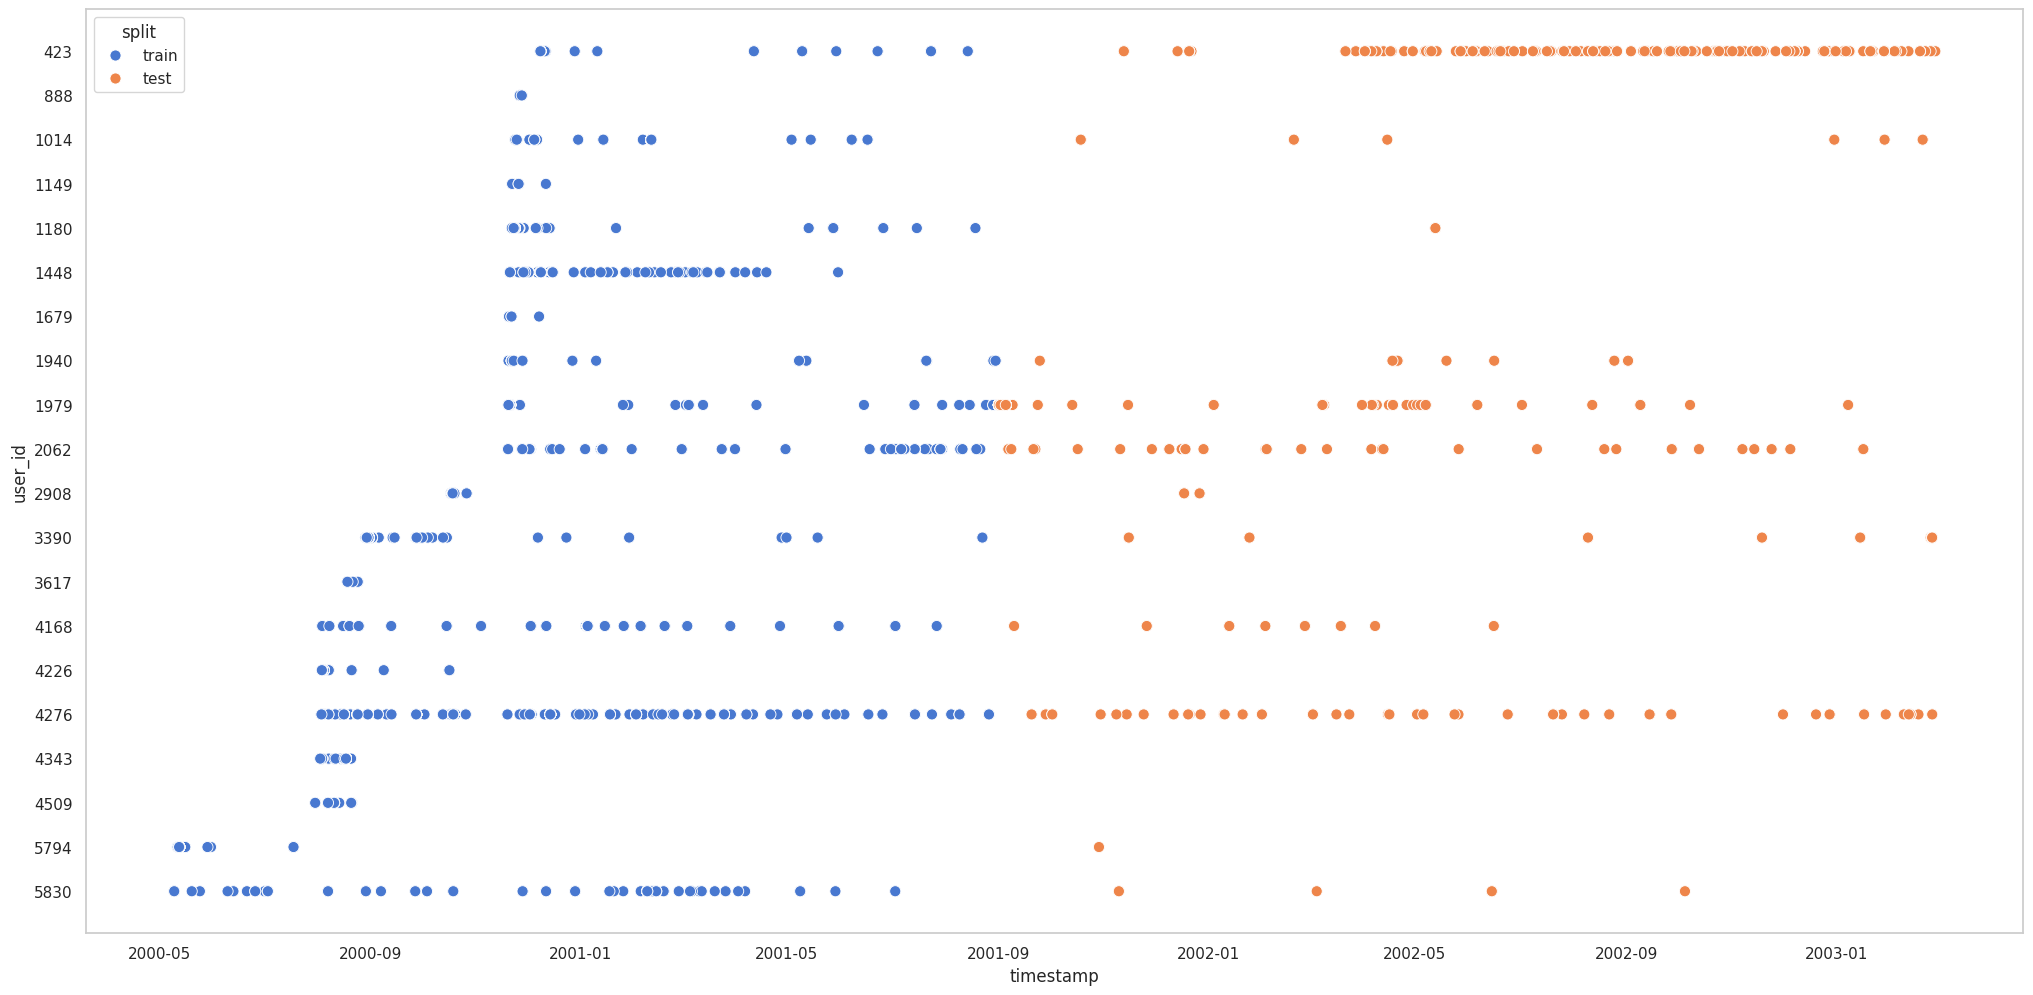

In [37]:
show_train_test(train, test)

In [38]:
get_df_info(train)

Total rows 26345, unique users: 20, unique items: 3281


In [39]:
get_df_info(test)

Total rows 1834, unique users: 12, unique items: 1399


### Learn more about the parameters `drop_cold_users`, `drop_cold_items`, `drop_zero_rel_in_test`

#### All parameters is false

In [40]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=False,
    drop_cold_items=False,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()`

In [41]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 300065, unique users: 2283, unique items: 3572


#### `drop_cold_users` is True 

In [42]:
date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=True,
    drop_cold_items=False,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_users=True`. Compared to the disabled flag, the number of users has decreased.

In [43]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 111169, unique users: 1113, unique items: 3459


#### `drop_cold_items` is True 

In [44]:
date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=False,
    drop_cold_items=True,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_items=True`. Compared to the disabled flag, the number of items has decreased.

In [45]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 299894, unique users: 2283, unique items: 3499


## class RandomSplitter()

Assign records into train and test at random.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [46]:
from replay.splitters import RandomSplitter

random_splitter = RandomSplitter(
    test_size=0.4,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column="user_id",
)

In [47]:
train, test = random_splitter.split(log_limit_20)

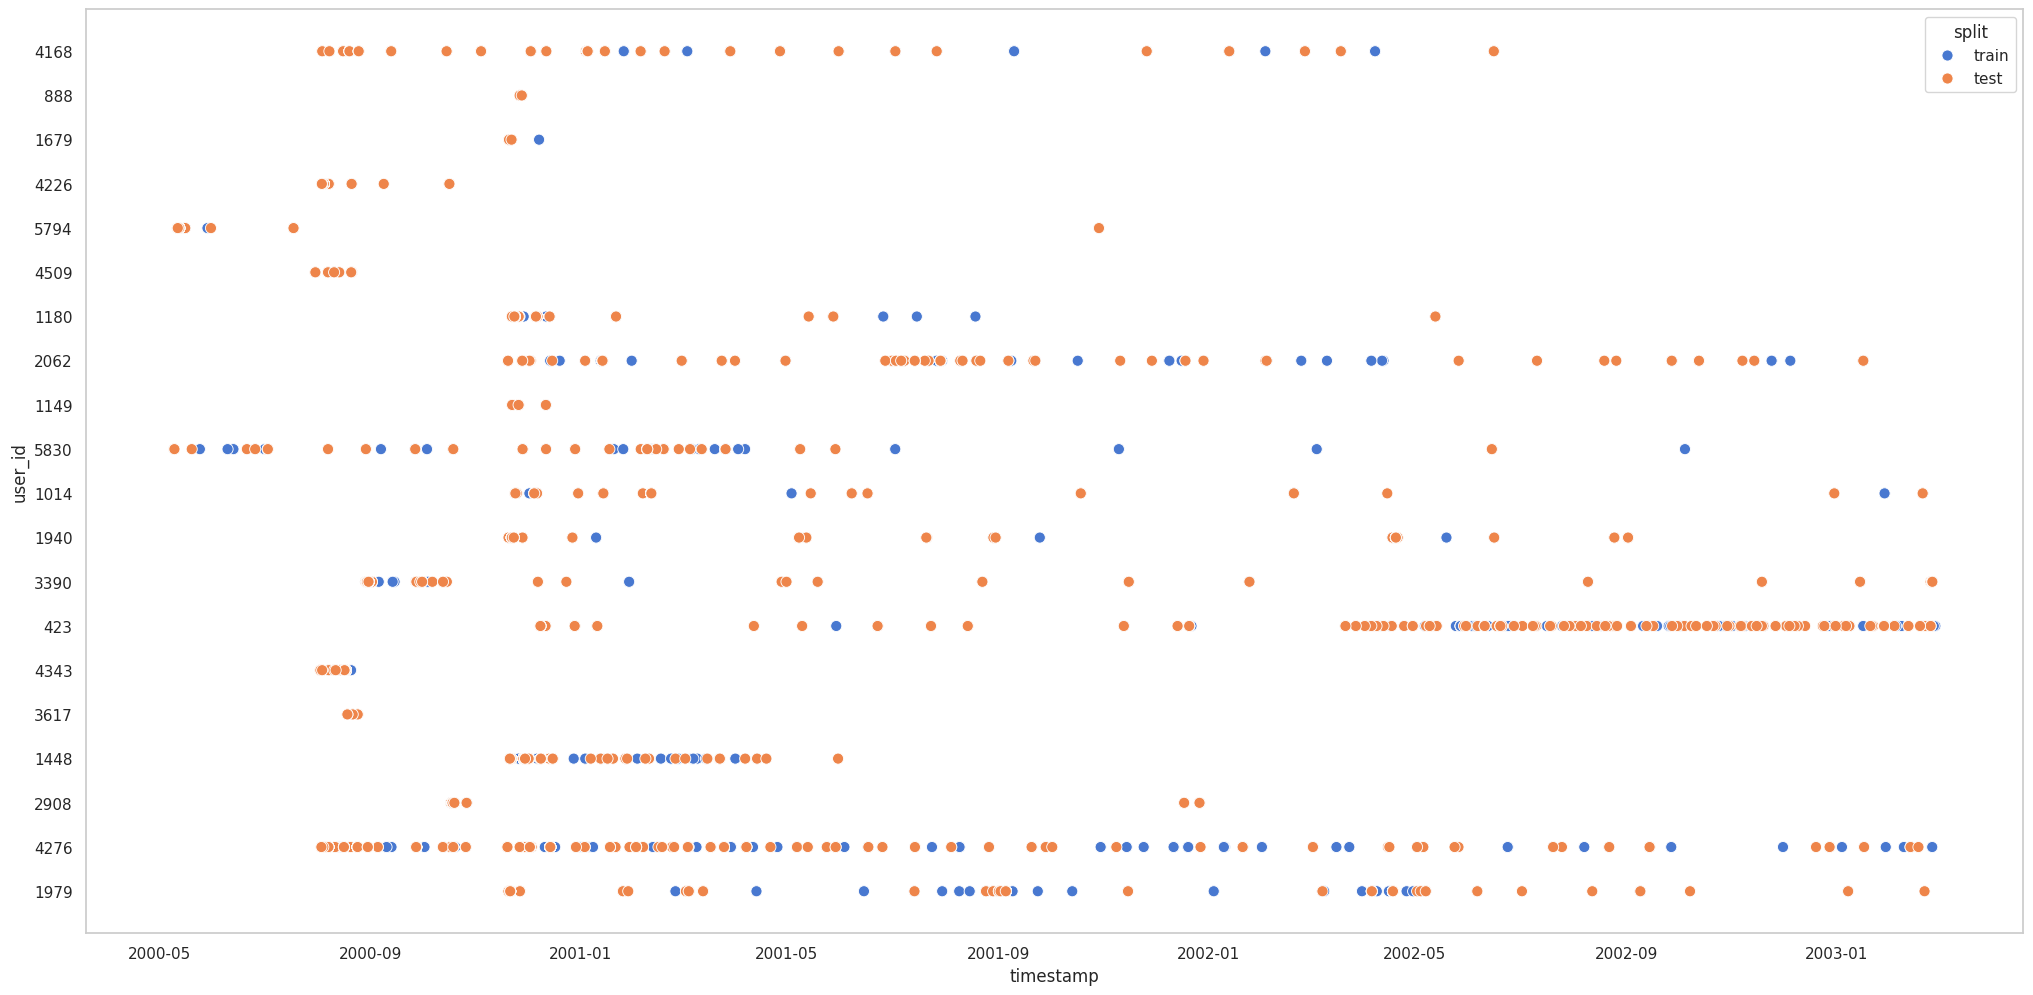

In [48]:
show_train_test(train, test)

In [49]:
get_df_info(train)

Total rows 16937, unique users: 20, unique items: 3143


In [50]:
get_df_info(test)

Total rows 11006, unique users: 20, unique items: 2757


## class NewUsersSplitter()

Only new users will be assigned to test set.
Splits log by timestamp so that test has `test_size` fraction of most recent users.

#### Parameters other than general

* `test_size` float 

In [87]:
from replay.splitters import NewUsersSplitter

new_user_splitter = NewUsersSplitter(
    test_size=0.3,
    query_column="user_id",
)

In [88]:
train, test = new_user_splitter.split(log_limit_20)

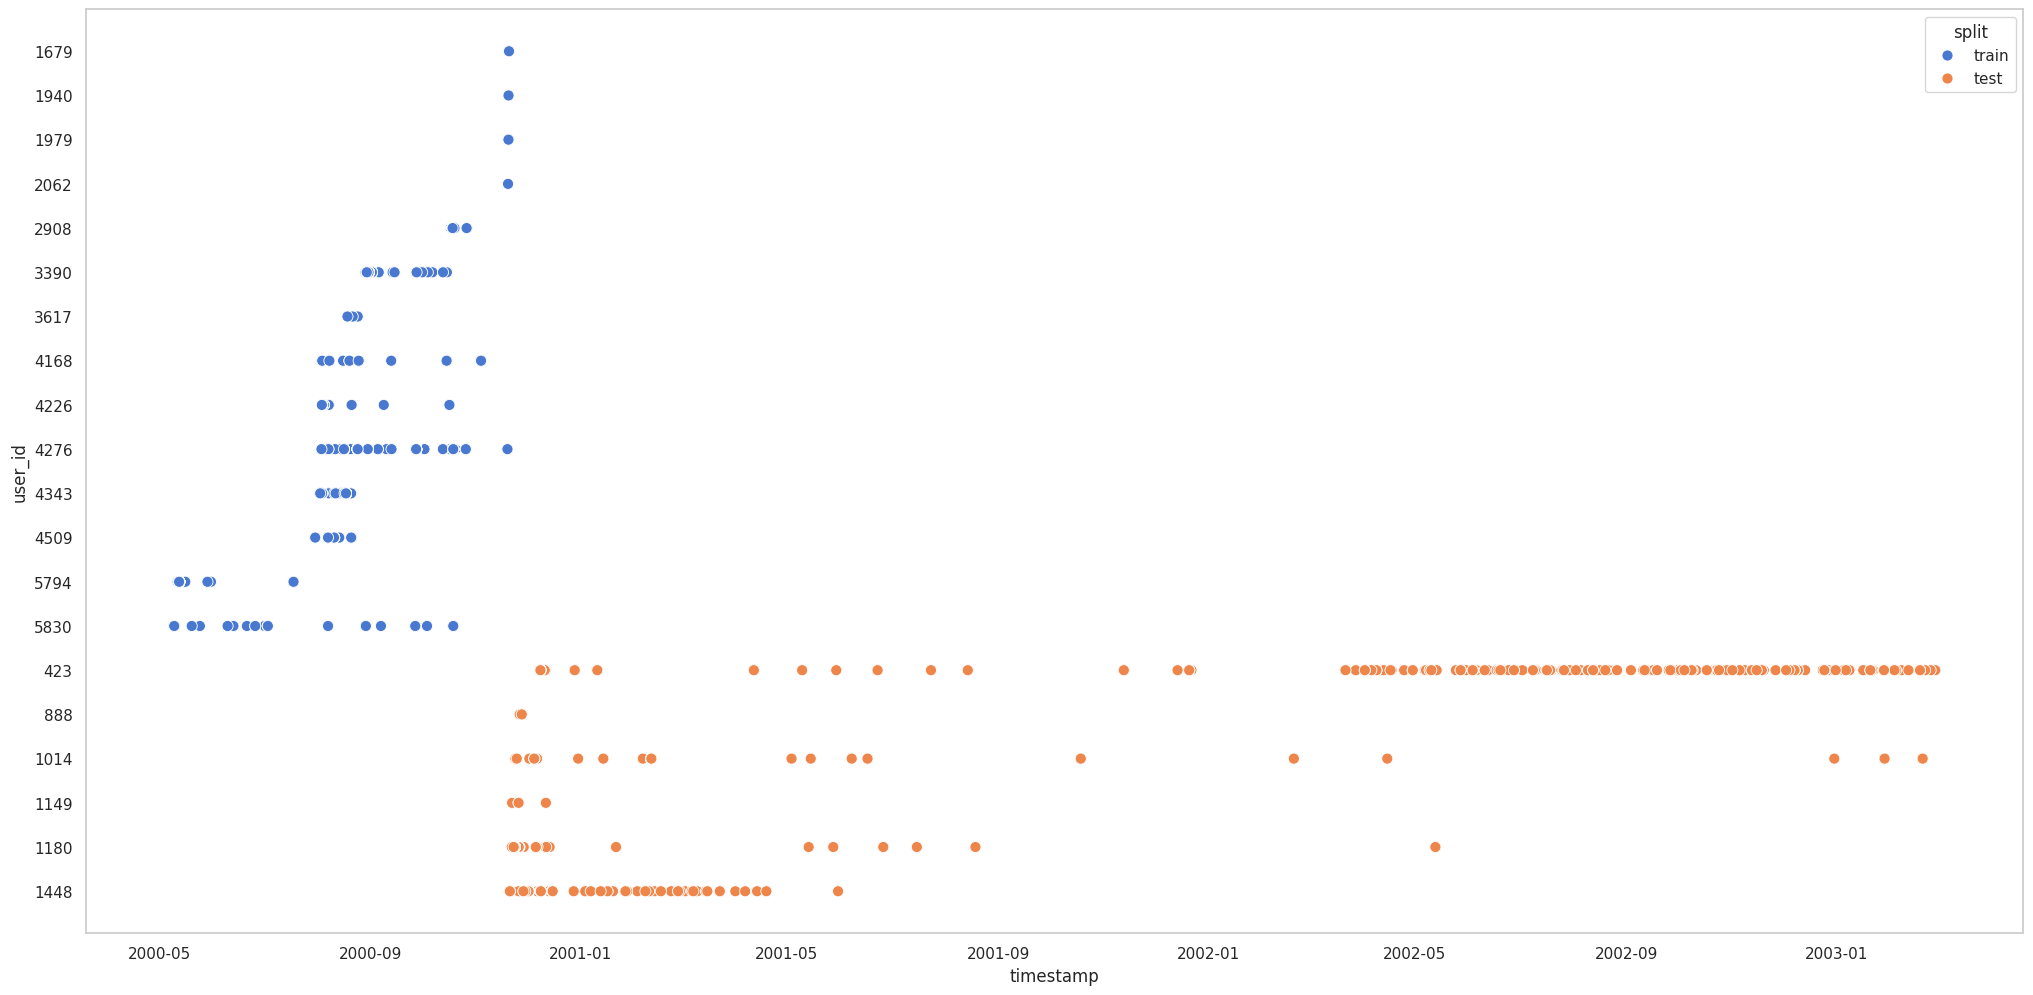

In [91]:
show_train_test(train, test)

In [54]:
get_df_info(train)

Total rows 13952, unique users: 14, unique items: 2931


In [55]:
get_df_info(test)

Total rows 8096, unique users: 6, unique items: 2757


## class ColdUserRandomSplitter()

Test set consists of all actions of randomly chosen users.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [56]:
from replay.splitters import ColdUserRandomSplitter

cold_user_random_splitter = ColdUserRandomSplitter(
    test_size=0.3,
    query_column="user_id",
)

In [92]:
train, test = cold_user_random_splitter.split(log_limit_20)

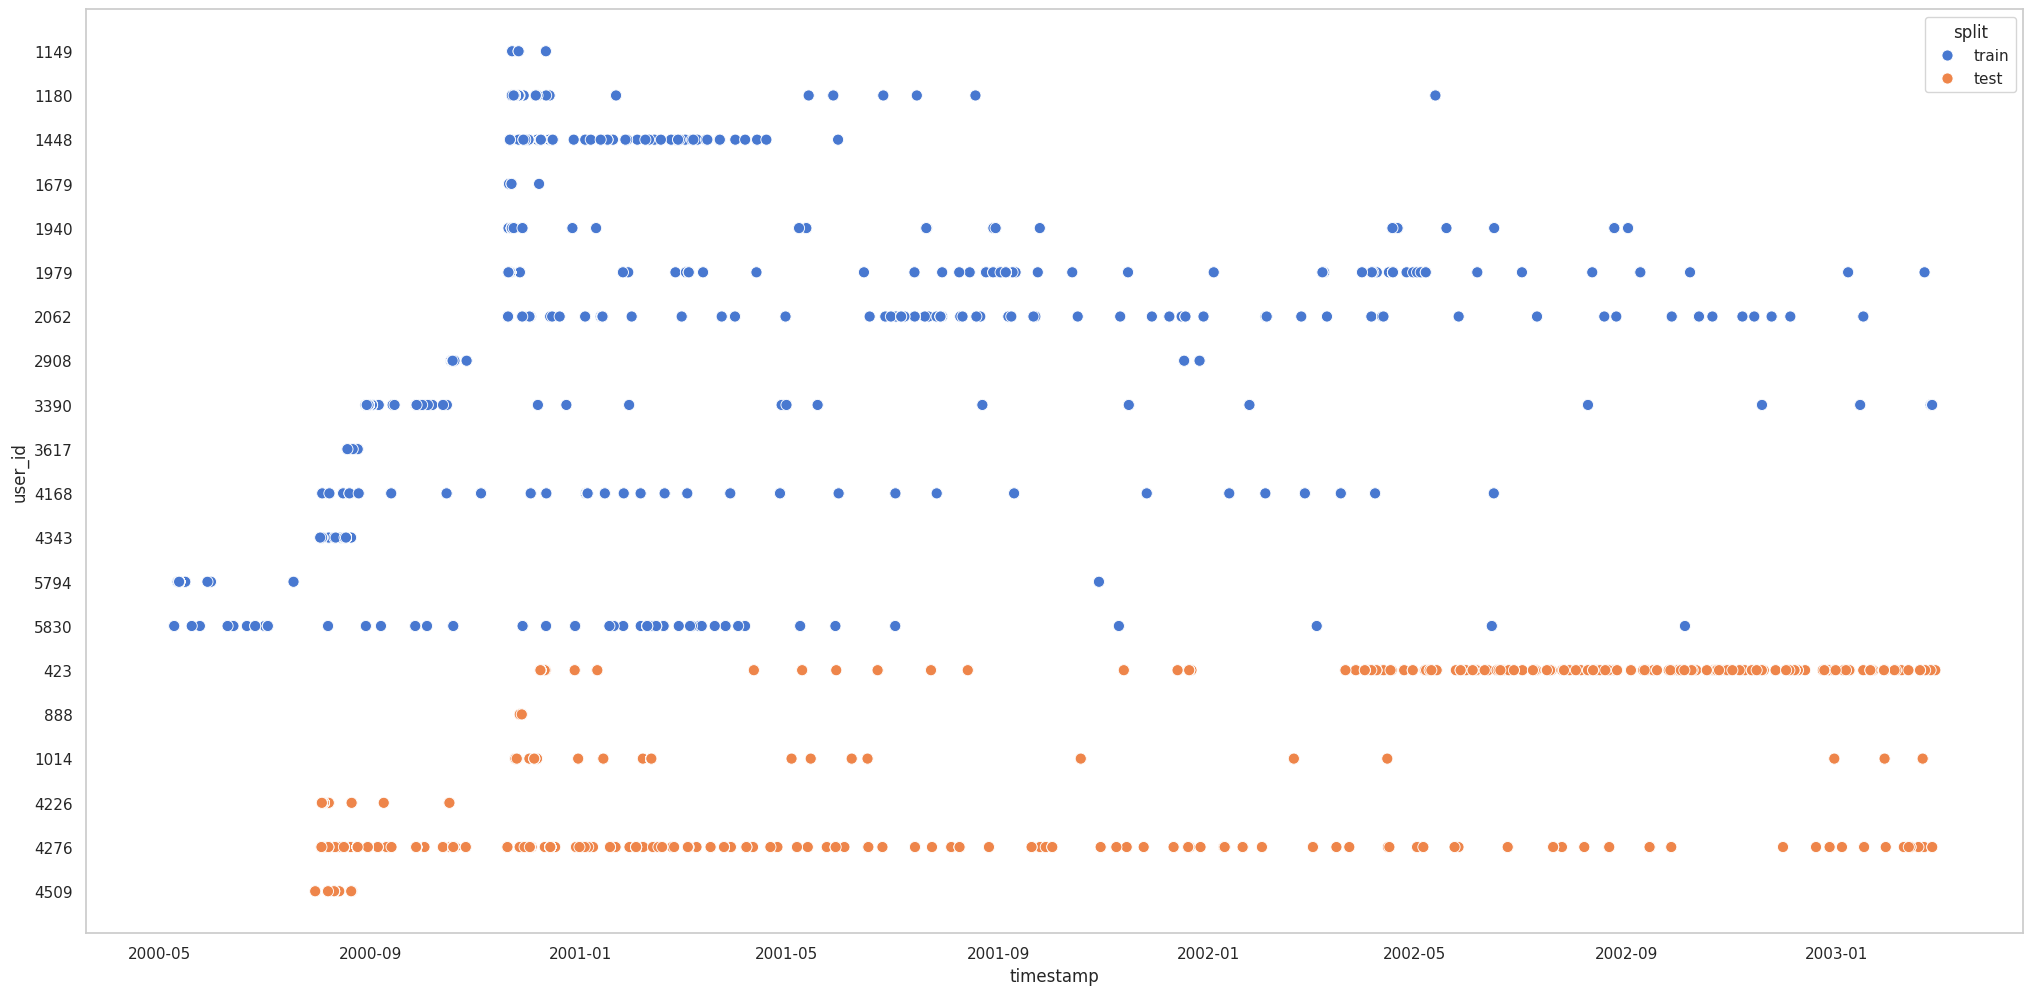

In [58]:
show_train_test(train, test)

In [59]:
get_df_info(train)

Total rows 19994, unique users: 14, unique items: 3228


In [60]:
get_df_info(test)

Total rows 8235, unique users: 6, unique items: 2838


## class TwoStageSplitter()

Split data by two columns.

#### Parameters other than general

* `item_test_size` Number of items to be added to the test for each user

* `user_test_size` Number of users to be added to the test

* `seed` random seed

In this example 10 users are randomly selected, 50 products are included in the test for each user. `shuffle` parameter is False. Separation in each selected user occurs on a timeline

In [42]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=False,
    query_column="user_id",
    first_divide_column="user_id",
)

In [43]:
train, test = user_splitter.split(log_limit_20)

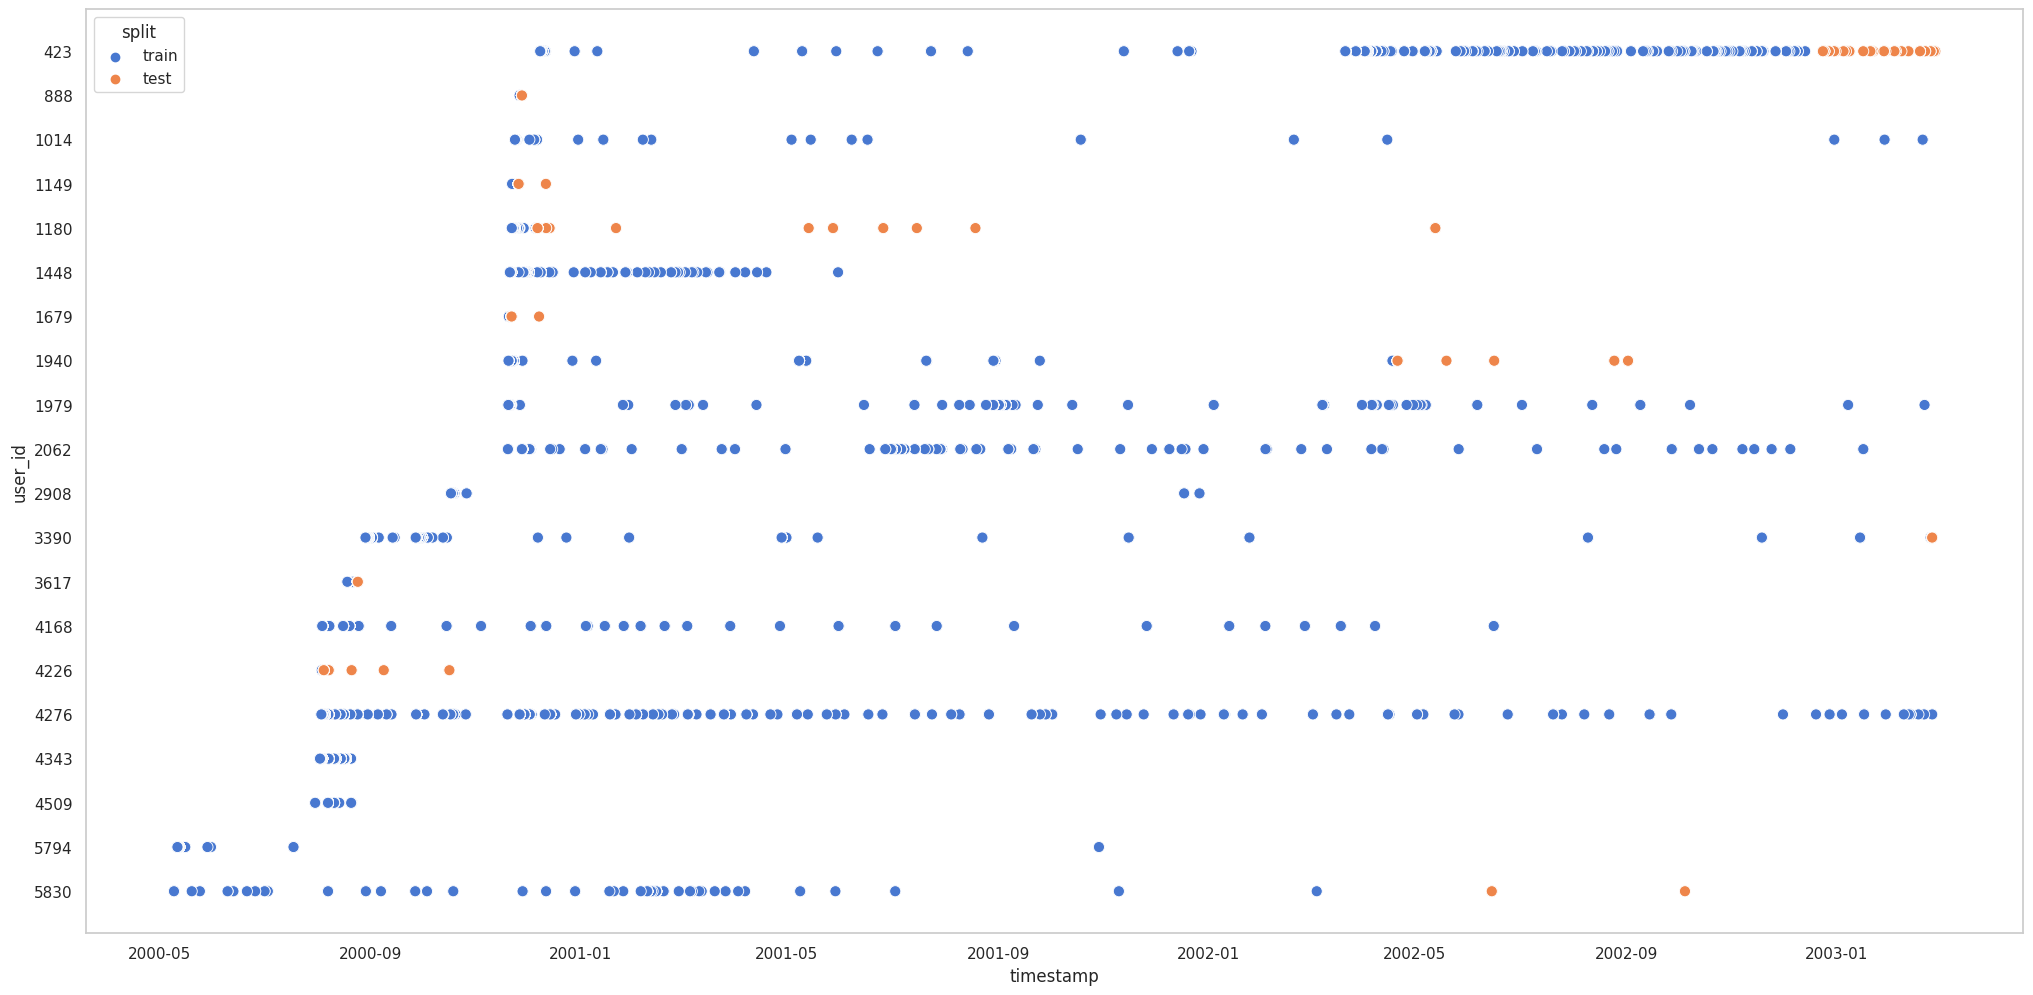

In [44]:
show_train_test(train, test)

In [45]:
get_df_info(train)

Total rows 27729, unique users: 20, unique items: 3320


In [46]:
get_df_info(test)

Total rows 500, unique users: 10, unique items: 459


In this example 10 users are randomly selected, 50 products are included in the test for each user. In this example `shuffle` parameter is True. Split in each selected user occurs random

In [47]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=True,
    query_column="user_id",
    first_divide_column="user_id",
)

In [48]:
train, test = user_splitter.split(log_limit_20)

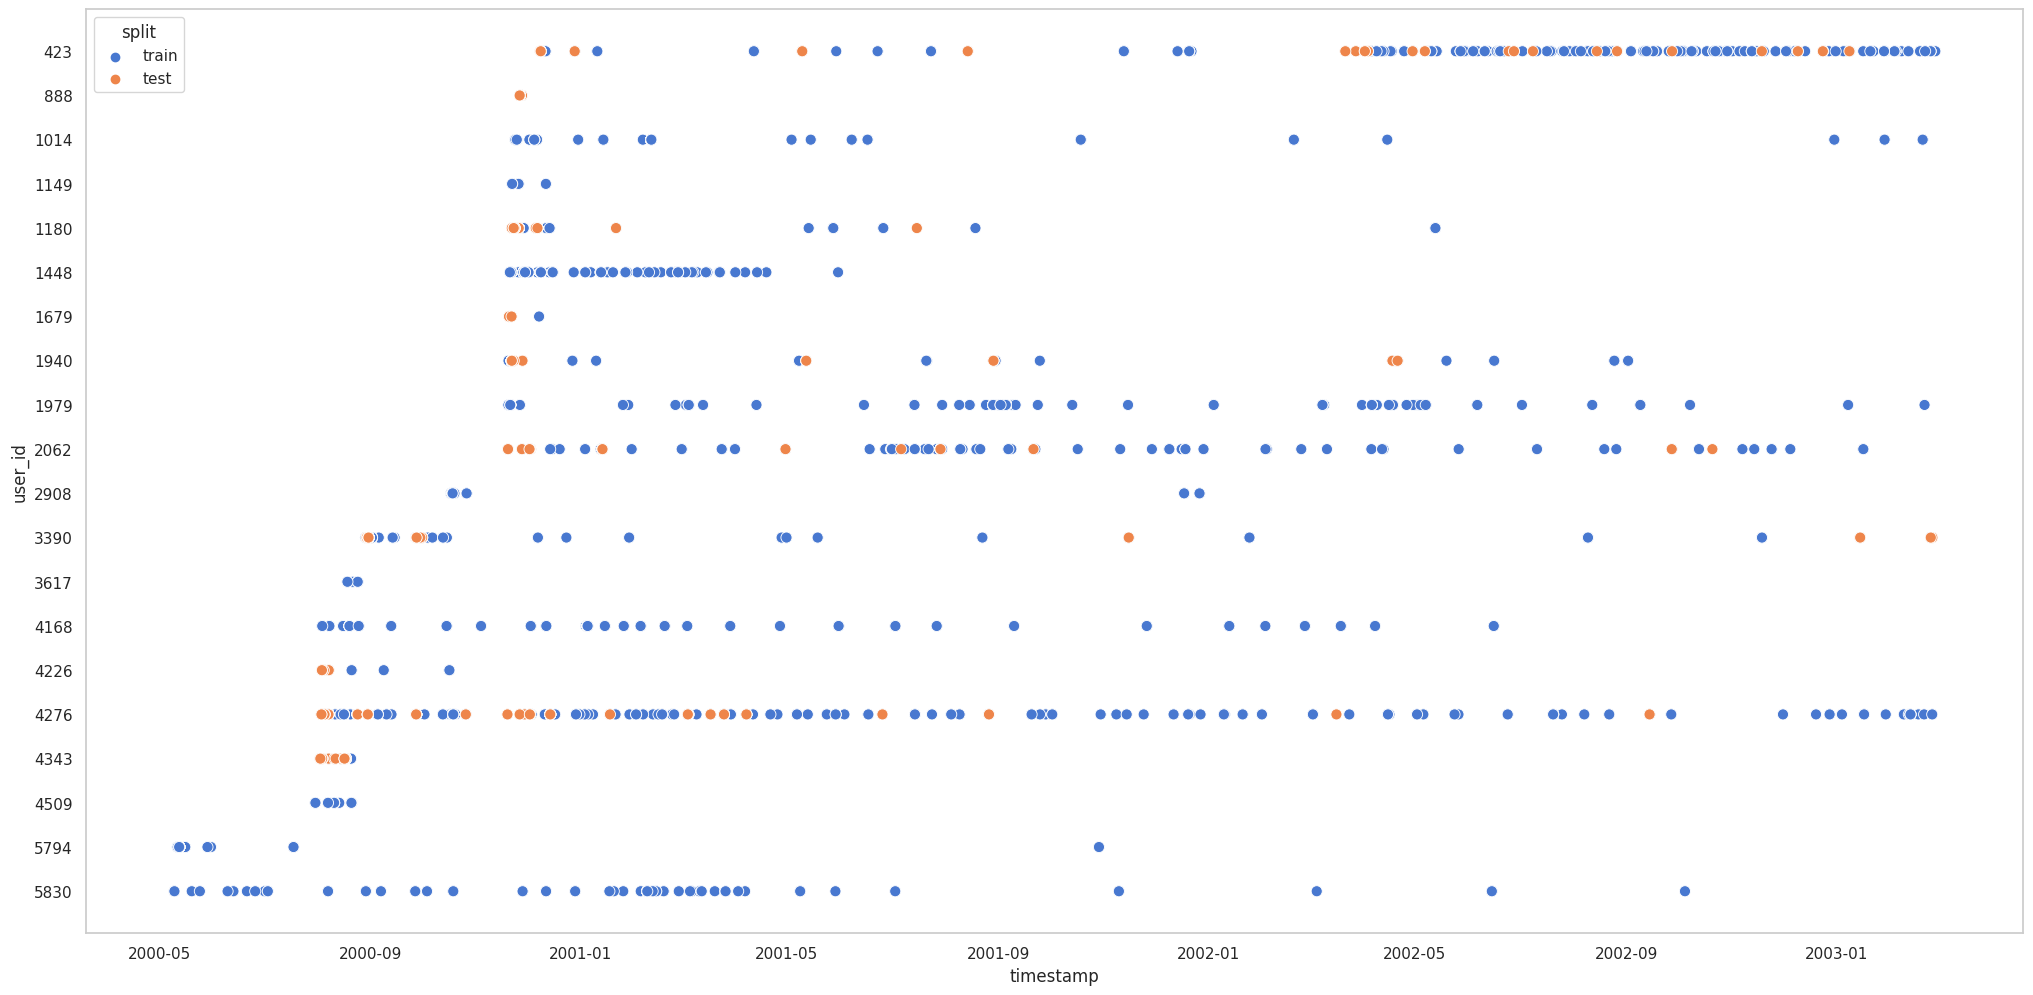

In [49]:
show_train_test(train, test)

In [50]:
get_df_info(train)

Total rows 27729, unique users: 20, unique items: 3322


In [51]:
get_df_info(test)

Total rows 500, unique users: 10, unique items: 466


You can use **float** as input for `item_test_size` or `user_test_size` parameters

In [52]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=0.5,
    second_divide_size=0.015,
    shuffle=True,
    query_column="user_id",
    first_divide_column="user_id",
)

In [53]:
train, test = user_splitter.split(log_limit_20)

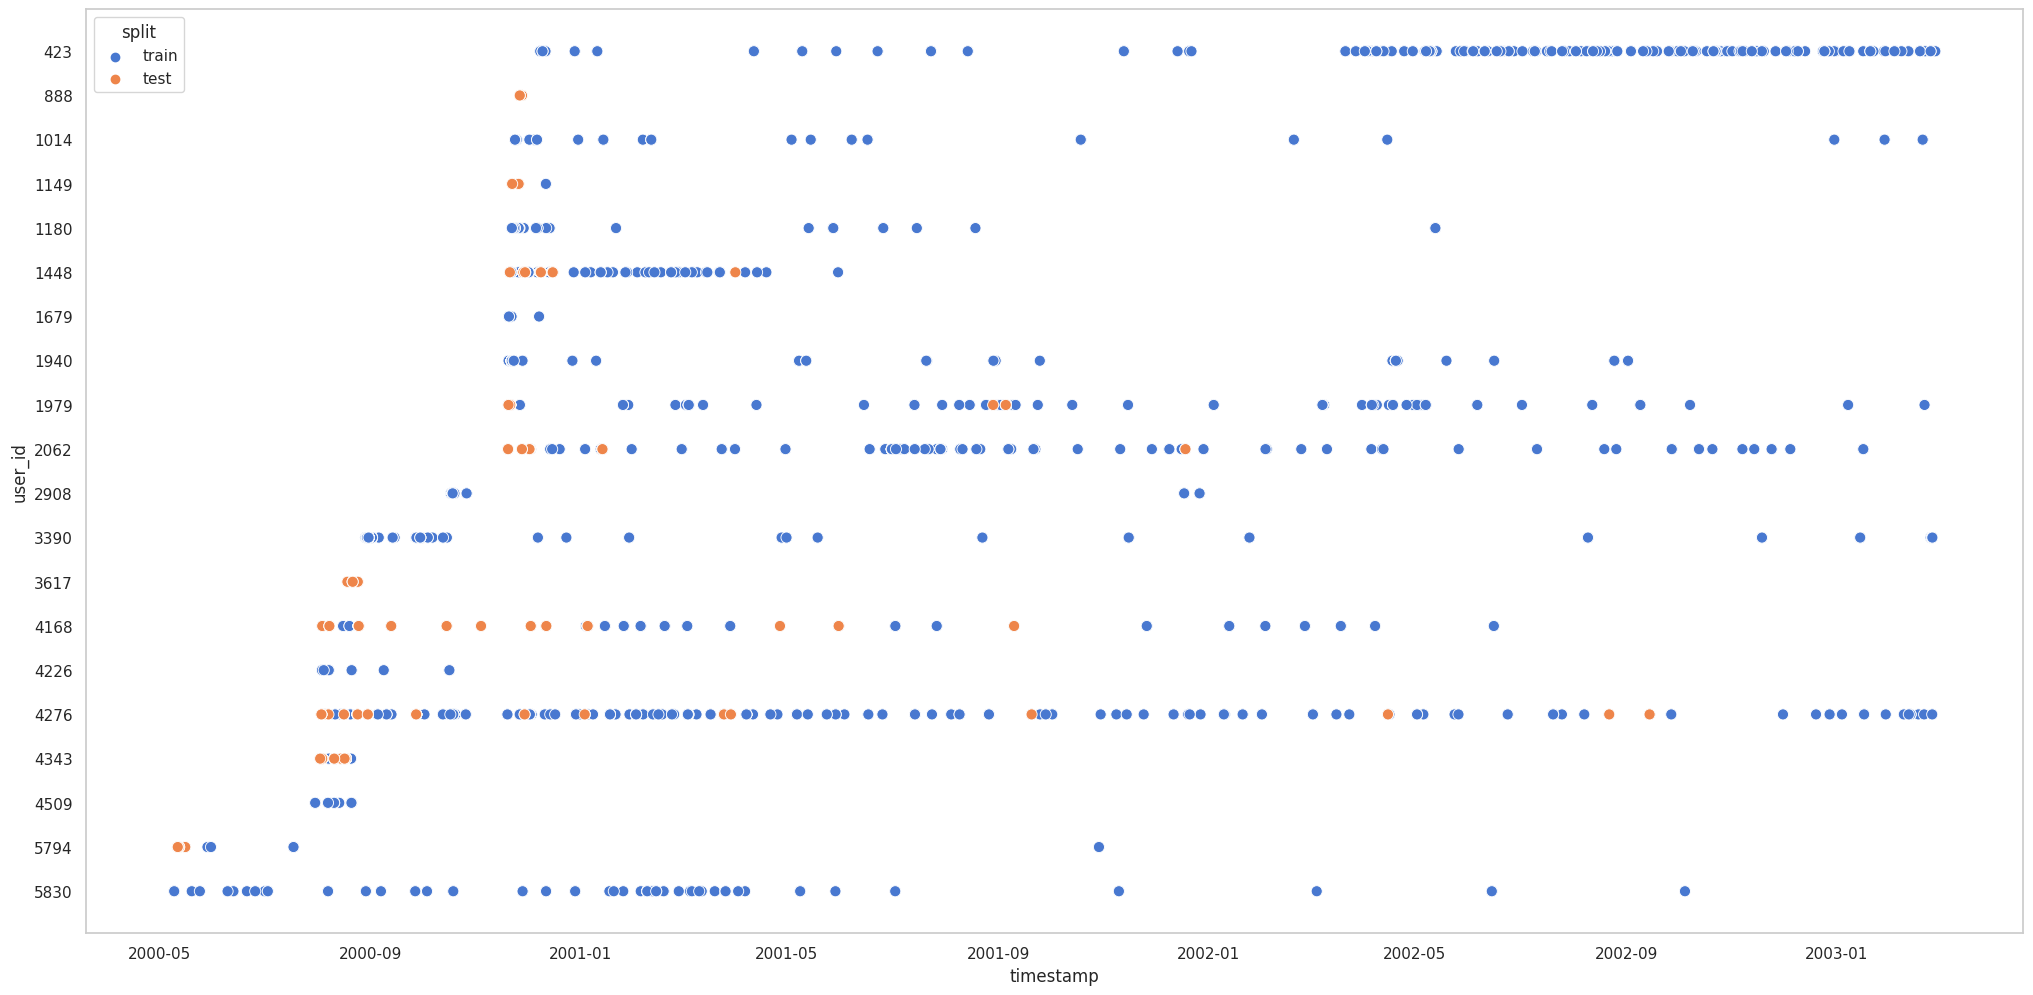

In [54]:
show_train_test(train, test)

In [55]:
get_df_info(train)

Total rows 28015, unique users: 20, unique items: 3321


In [56]:
get_df_info(test)

Total rows 214, unique users: 10, unique items: 208


## Class RatioSplitter

Split interactions into train and test by ratio. Split is made for each user separately.

#### Parameters other than general

* `test_size` float - test size 0 to 1

* `divide_column` str - name of the column used to group interactions (e.g., for each user). The split is performed independently for each unique value in this column (default: `query_id`)

* `min_interactions_per_group` int - minimum number of interactions a group
    must have to be split. Groups with fewer interactions will be assigned entirely
    to the training set (default: None)

In [67]:
from replay.splitters import RatioSplitter

ratio_splitter = RatioSplitter(
    test_size=0.1,
    divide_column="user_id",
    query_column="user_id",
)

In [68]:
train, test = ratio_splitter.split(log_limit_20)

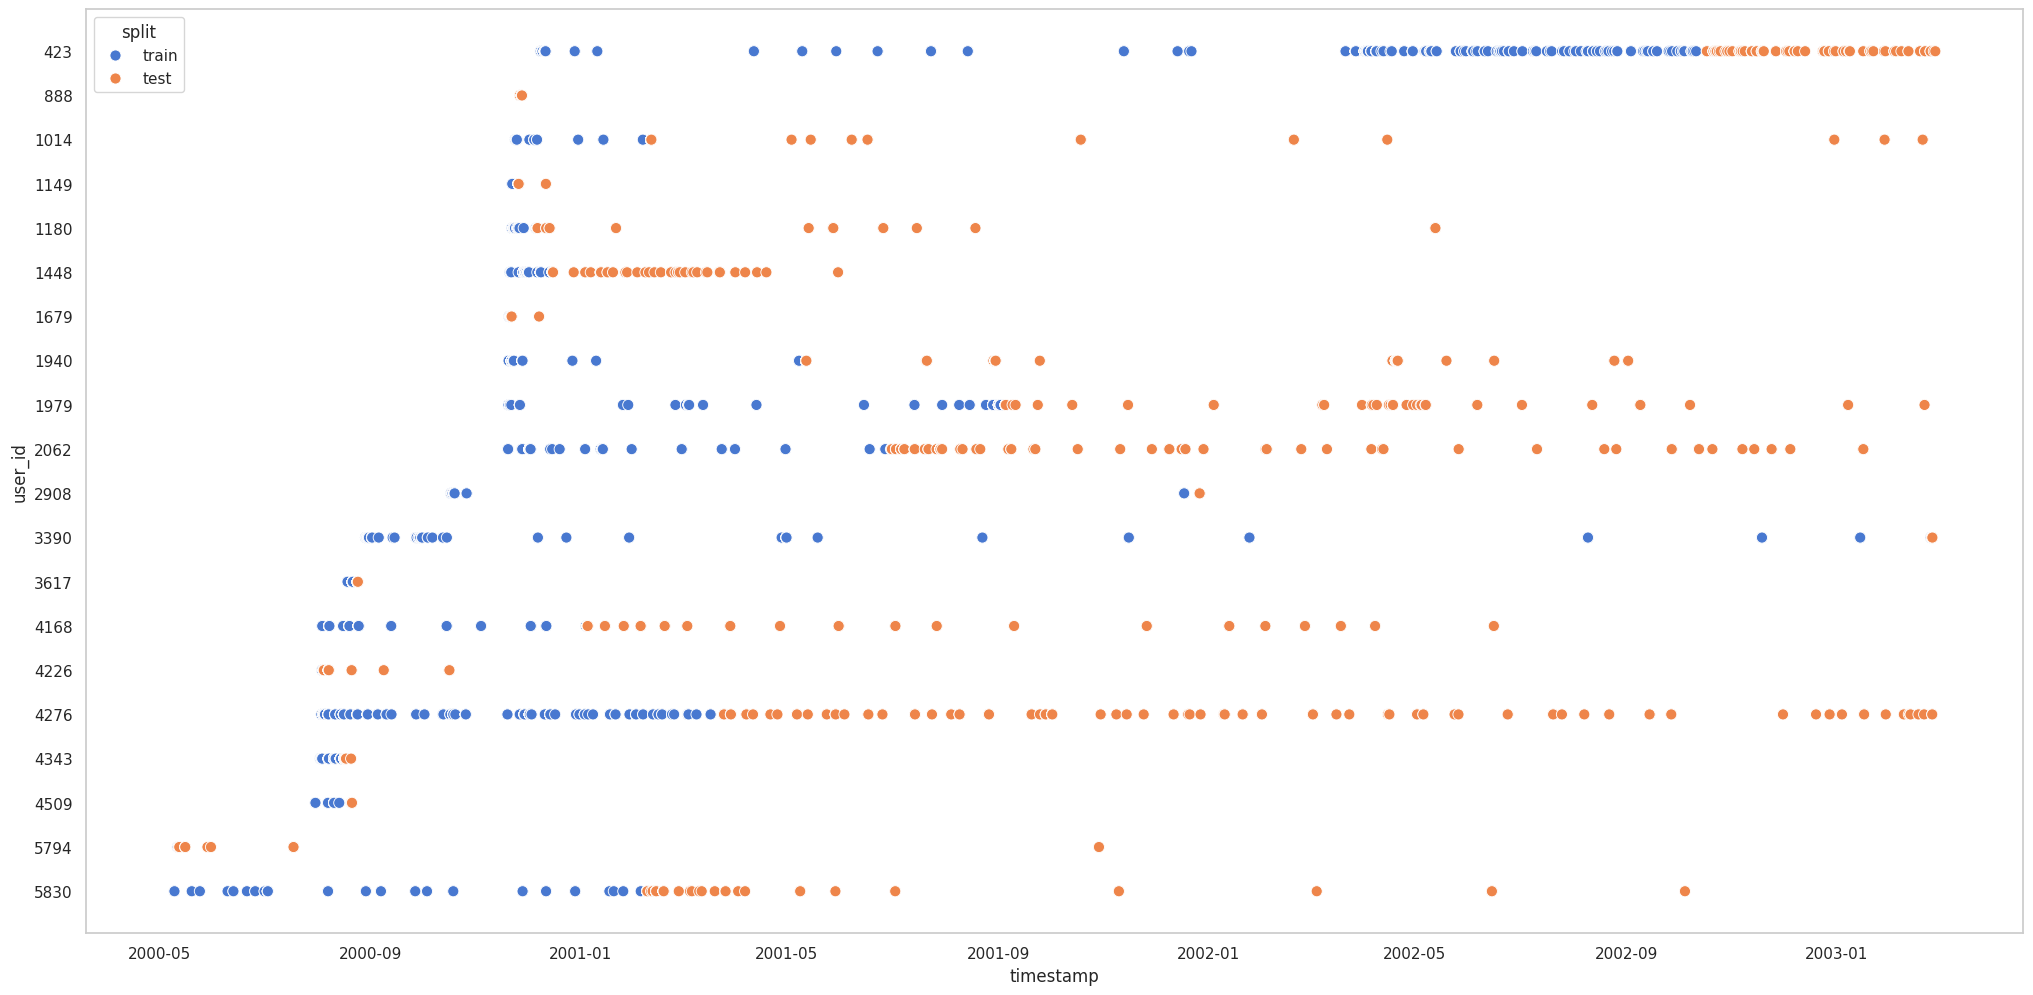

In [69]:
show_train_test(train, test)

In [70]:
get_df_info(train)

Total rows 25410, unique users: 20, unique items: 3232


In [71]:
get_df_info(test)

Total rows 2819, unique users: 20, unique items: 1859


## class LastNsplitter


Divides interactions by the last N interactions/time interval for each user.

#### Parameters other than general

* `N` int - number of interactions/time interval for separation

* `divide_column` str - name of the column used to group interactions (e.g., for each user). The split is performed independently for each unique value in this column (default: `query_id`)

* `time_column_format` str - the time column format required to convert the time column to the unix_timestamp type. If strategy is set to interactions, this parameter can be omitted. If the timestamp column has already been converted to the unix_timestamp type, this parameter can be omitted (default: `yyyy-MM-dd HH:mm:ss`)

* `strategy` StrategyName - the type of data separation. It should be interactions or timedelta (default: `interactions`)

In [80]:
from replay.splitters import LastNSplitter

last_n_splitter = LastNSplitter(
    N=50,
    divide_column="user_id",
    query_column="user_id",
)

In [81]:
train, test = last_n_splitter.split(log_limit_20)

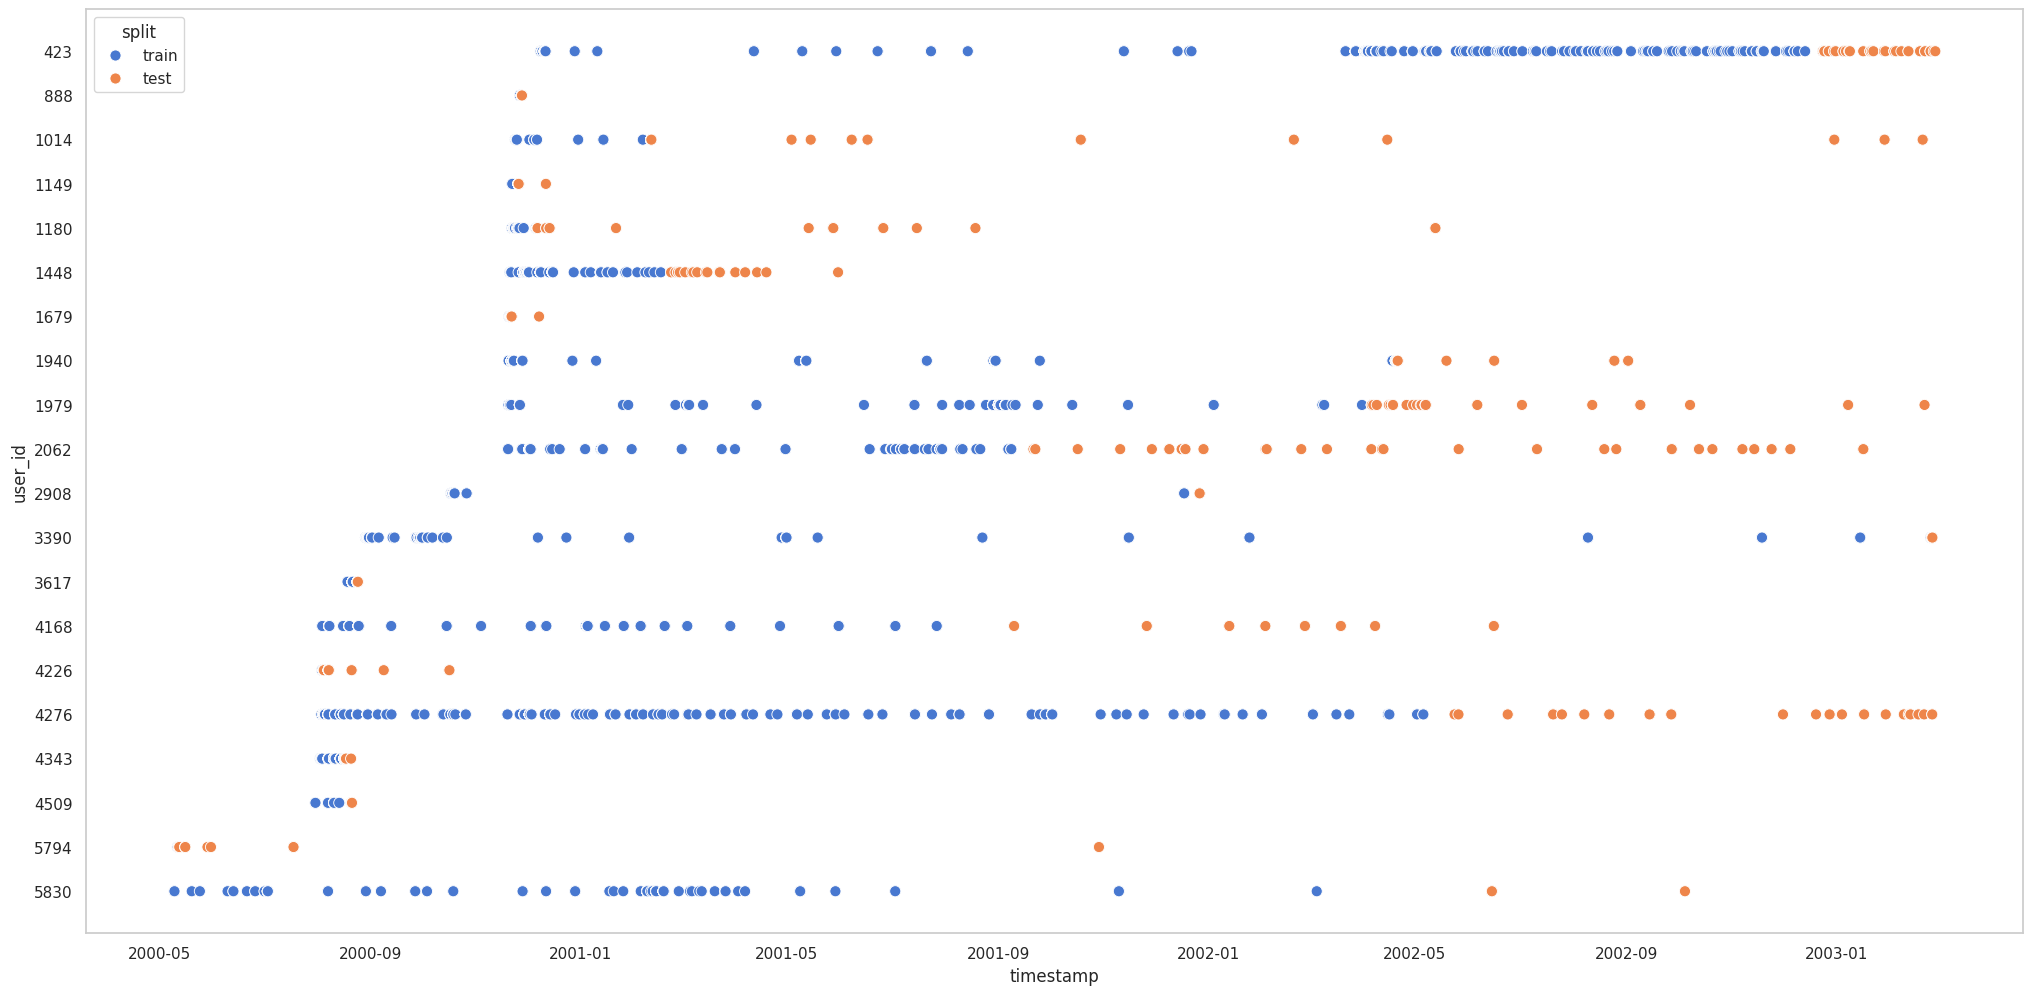

In [82]:
show_train_test(train, test)

In [83]:
get_df_info(train)

Total rows 27229, unique users: 20, unique items: 3294


In [84]:
get_df_info(test)

Total rows 1000, unique users: 20, unique items: 836


If the `strategy` is timedelta, then `N` is interpreted as seconds

In [140]:
last_n_splitter = LastNSplitter(
    N=3,
    divide_column="user_id",
    query_column="user_id",
    strategy="timedelta",
)

In [141]:
train, test = last_n_splitter.split(log_limit_20)

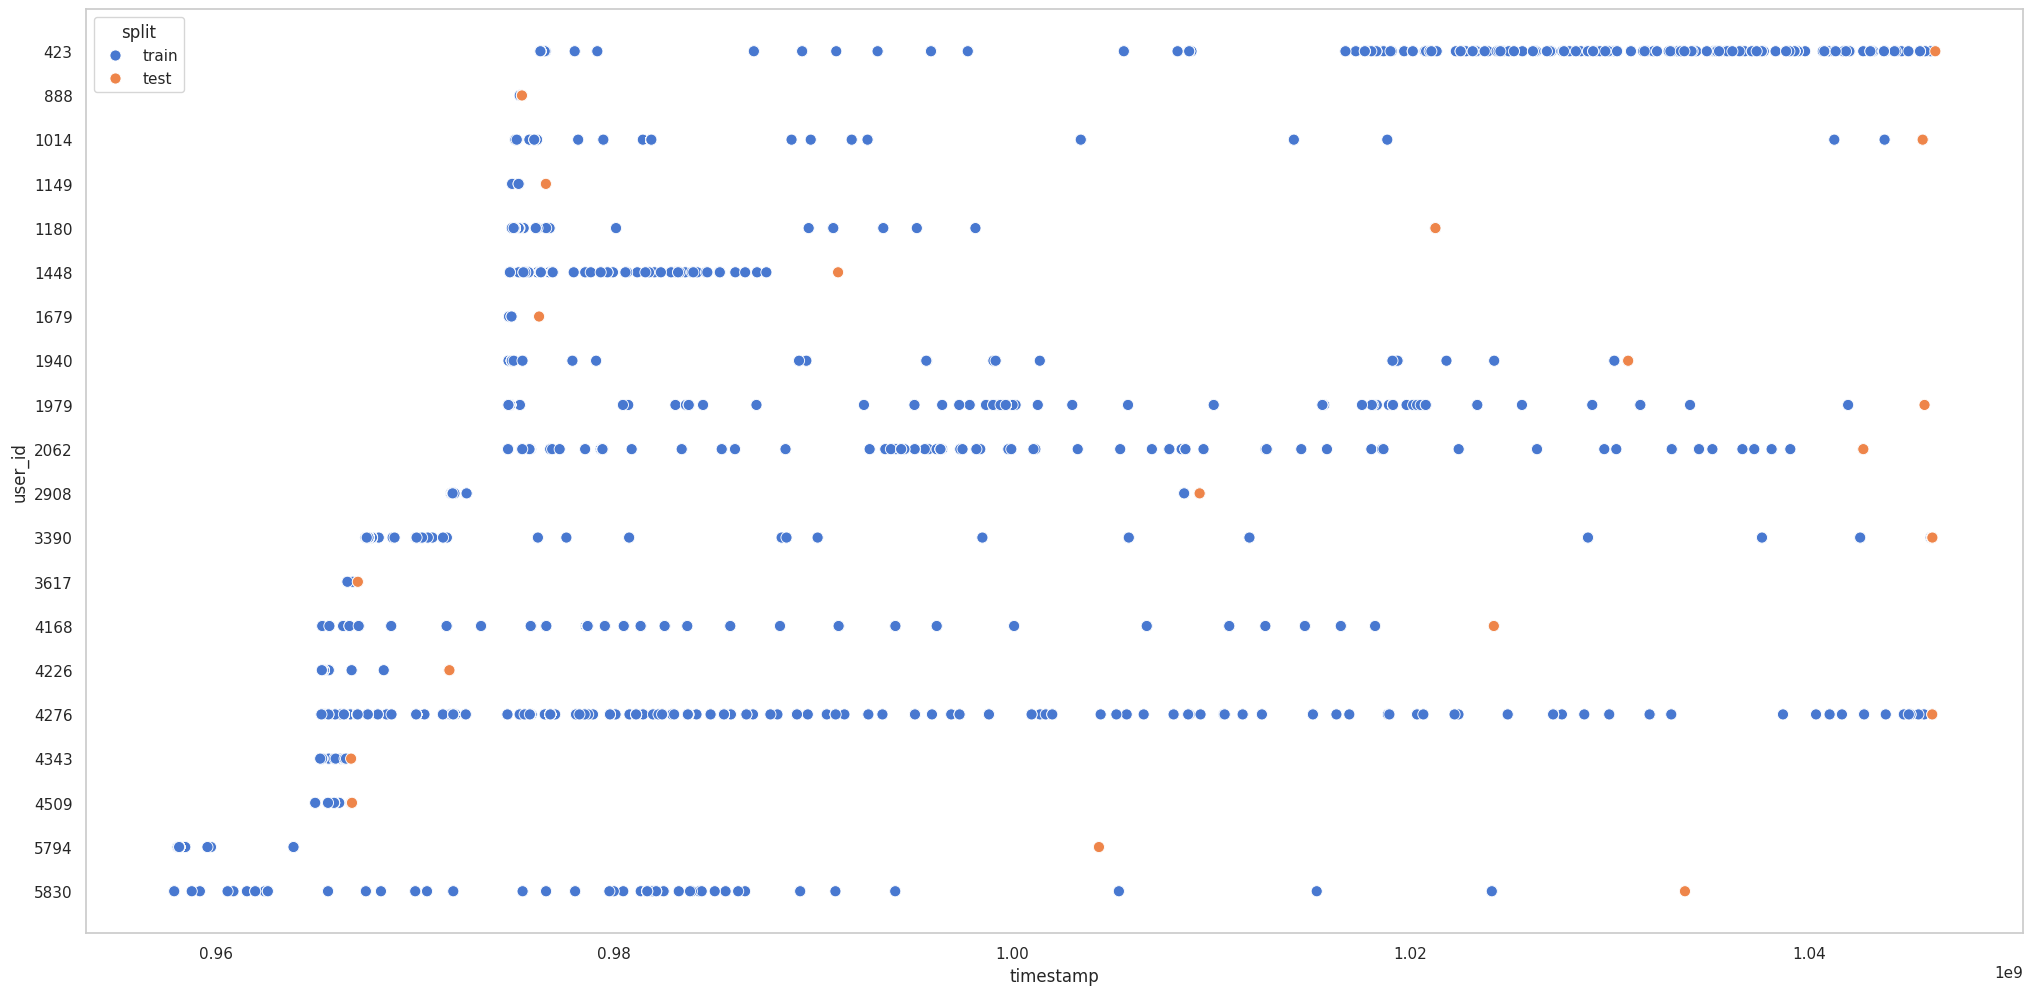

In [142]:
show_train_test(train, test)

In [143]:
get_df_info(train)

Total rows 28196, unique users: 20, unique items: 3325


In [144]:
get_df_info(test)

Total rows 33, unique users: 20, unique items: 33


## RandomTargetNextNSplitter

RandomTargetNextNSplitter creates a randomized “next-N” target per user. For each user, interactions are sorted by time and a random cut index r is sampled uniformly from [0, user_events_count − 1]. All events with rank < r form the input subset; the next N events [r, r+N) form the target. Events after r+N are dropped. This preserves a contiguous next-N target while ensuring reproducibility via a seed.

Parameters
- N (int, default 1): Number of consecutive target events after the random cut for each user. Must be >= 1.
- divide_column - name of column for dividing.
- seed (int | None, default None): Random seed for reproducible per-user cut positions.

Notes
- If fewer than N events remain after r, the target will contain fewer than N events.
- If r = 0, the input for that user can be empty.
- A valid timestamp column is required to define the chronological order.

In [ ]:
from replay.splitters import RandomTargetNextNSplitter, TimeSplitter
from replay.preprocessing.filters import filter_cold
from replay.preprocessing.utils import merge_subsets

In [21]:

random_target_splitter = RandomTargetNextNSplitter(
    N=30, seed=44,
    divide_column="user_id",
    query_column="user_id"
)

train, test = random_target_splitter.split(log_limit_20)

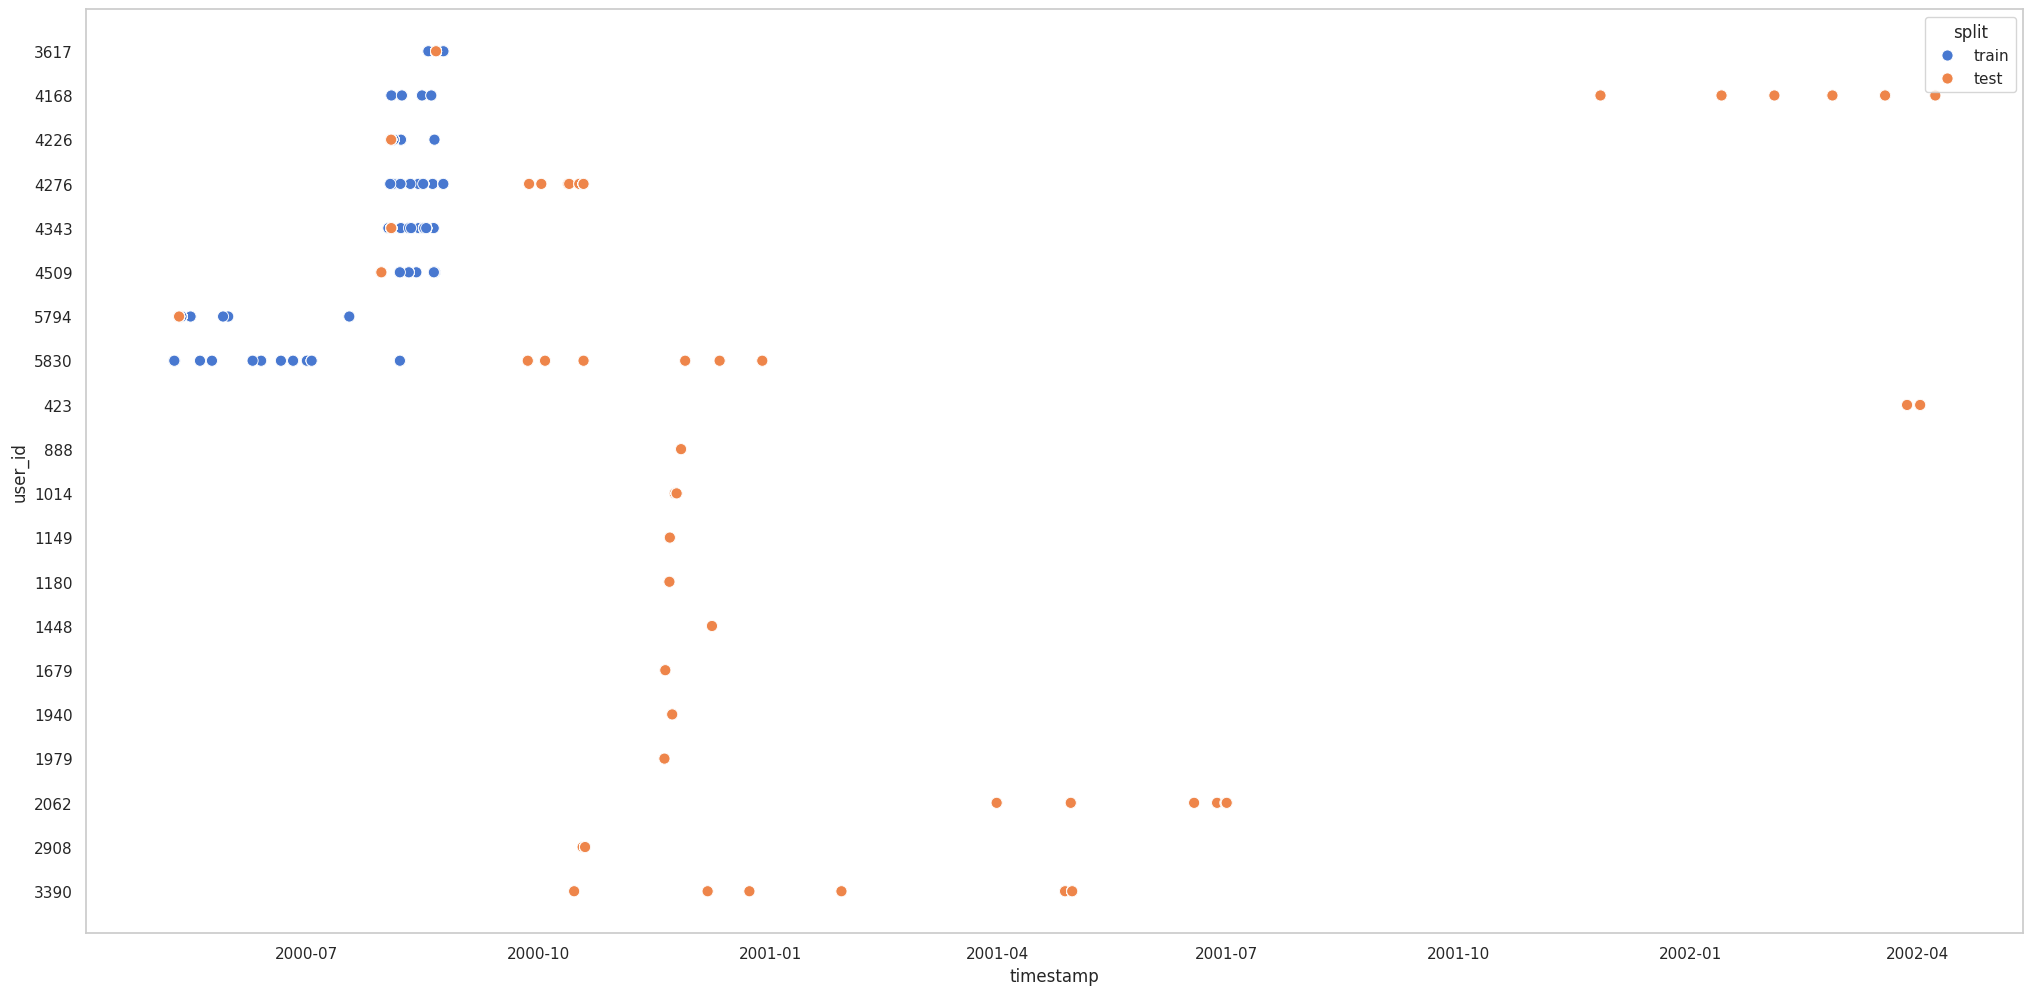

In [55]:
show_train_test(train, test)

## Global temporal split + LOO target

This split evaluates sequential models by training on interactions from an earlier global time window and testing on a strictly later window. In the test (and validation) window, each user’s last interaction is selected as the target (leave-one-out), while all of the user’s preceding interactions constitute the input context. This setup preserves temporal causality and measures the model’s ability to predict the next item from a user’s recent history.

In this section, we will show an example of how to construct this split using the ready-to-use splitters and filters provided by RePlay.

In [ ]:
from replay.splitters import TimeSplitter, LastNSplitter
from replay.preprocessing.filters import filter_cold, MinCountFilter
from replay.preprocessing.utils import merge_subsets  

Split interactions into `train` and `test_holdout` by global time

In [87]:
time_splitter = TimeSplitter(
    time_threshold=log_limit_20["timestamp"].quantile(0.5),
    query_column="user_id",
)

train, test_holdout = time_splitter.split(log_limit_20)

Remove short sequences from train

In [88]:
min_count_filter = MinCountFilter(num_entries=2, groupby_column="user_id")
train = min_count_filter.transform(train)

Since standard sequential recommendation models do not handle cold items, they should be removed from `test_holdout`.

In [89]:
test_holdout = filter_cold(test_holdout, train, mode="items")

Based on `test_holdout`, we will create `test_input` and `test_target` and combine `test_input` with `train` to obtain the user's complete history at prediction time.

However, in this example we will omit the combination step for simplicity and for clearer data visualization.

In [90]:
last_n_splitter = LastNSplitter(
    N=10,
    divide_column="user_id",
    query_column="user_id",
)
test_input, test_target = last_n_splitter.split(test_holdout)

# test_input = merge_subsets([test_input, train])

Remove cold users—those with an empty history in `test_input`.

In [91]:
test_target = filter_cold(test_target, test_input, mode="users", query_column="user_id")

In [92]:
both_in_train_and_test = train[train["user_id"].isin(test_holdout["user_id"].unique())]

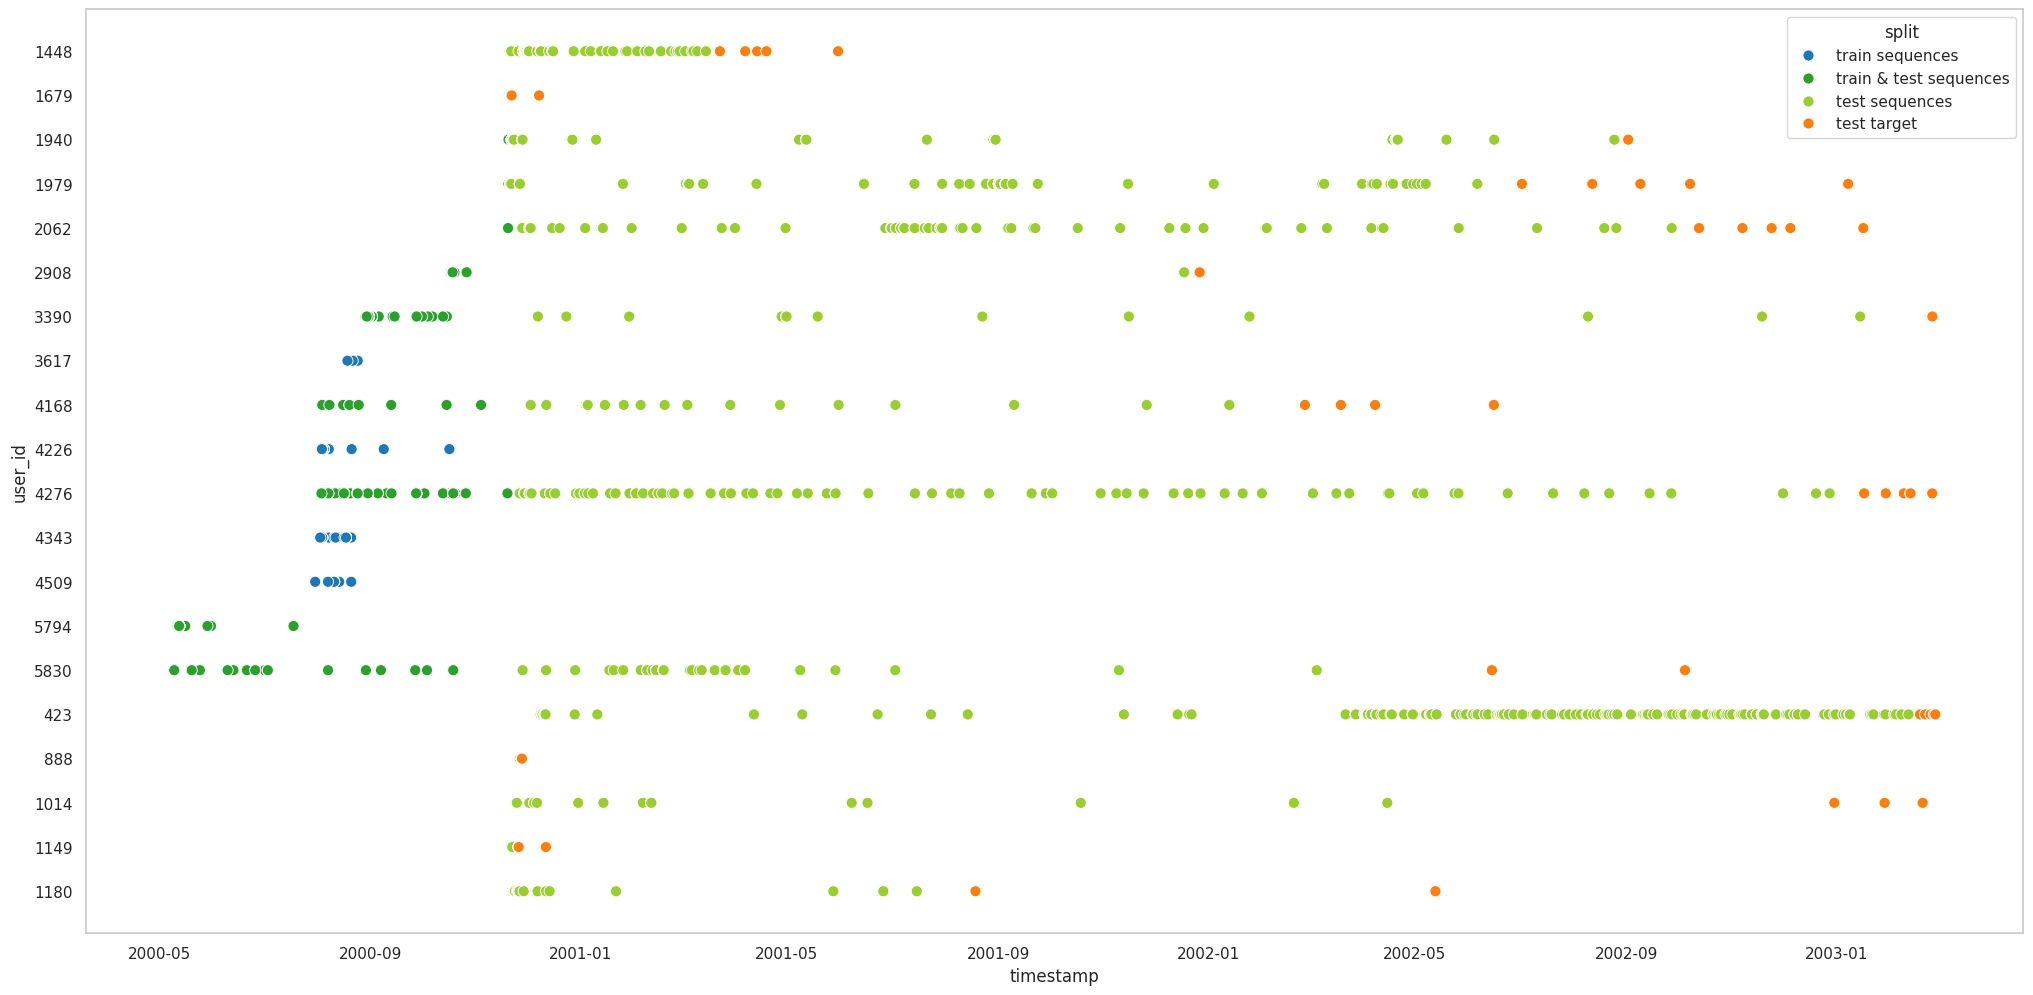

In [93]:
show_frames(
    [
        train,
        both_in_train_and_test,
        test_input,
        test_target,
    ],
    ["train sequences", "train & test sequences", "test sequences", "test target"],
)

## Global temporal split + random target

This split evaluates sequential models by training on interactions from an earlier global time window and testing on a strictly later window. In the test (and validation) window, each user’s target is chosen at a random cut within the holdout sequence: all interactions before the cut form the input context, while the next N interactions (typically N=1) serve as targets; interactions after that window are discarded. This setup preserves temporal causality and measures the model’s ability to predict upcoming item(s) from a user’s recent history.

In this section, we will show an example of how to construct this split using the ready-to-use splitters and filters provided by RePlay.

In [ ]:
from replay.splitters import TimeSplitter, RandomTargetNextNSplitter
from replay.preprocessing.filters import filter_cold, MinCountFilter
from replay.preprocessing.utils import merge_subsets  

Split interactions into `train` and `test_holdout` by global time

In [111]:
time_splitter = TimeSplitter(
    time_threshold=log_limit_20["timestamp"].quantile(0.5),
    query_column="user_id",
)

train, test_holdout = time_splitter.split(log_limit_20)

Remove short sequences from train

In [112]:
min_count_filter = MinCountFilter(num_entries=2, groupby_column="user_id")
train = min_count_filter.transform(train)

Since standard sequential recommendation models do not handle cold items, they should be removed from `test_holdout`.

In [113]:
test_holdout = filter_cold(test_holdout, train, mode="items")

Based on `test_holdout`, we will create `test_input` and `test_target` and combine `test_input` with `train` to obtain the user's complete history at prediction time.

However, in this example we will omit the combination step for simplicity and for clearer data visualization.

In [114]:
random_target_splitter = RandomTargetNextNSplitter(
    N=10,
    divide_column="user_id",
    query_column="user_id",
    seed=45,
)
test_input, test_target = random_target_splitter.split(test_holdout)

# test_input = merge_subsets([test_input, train])

Remove cold users—those with an empty history in `test_input`.

In [115]:
test_target = filter_cold(test_target, test_input, mode="users", query_column="user_id")

In [116]:
both_in_train_and_test = train[train["user_id"].isin(test_holdout["user_id"].unique())]

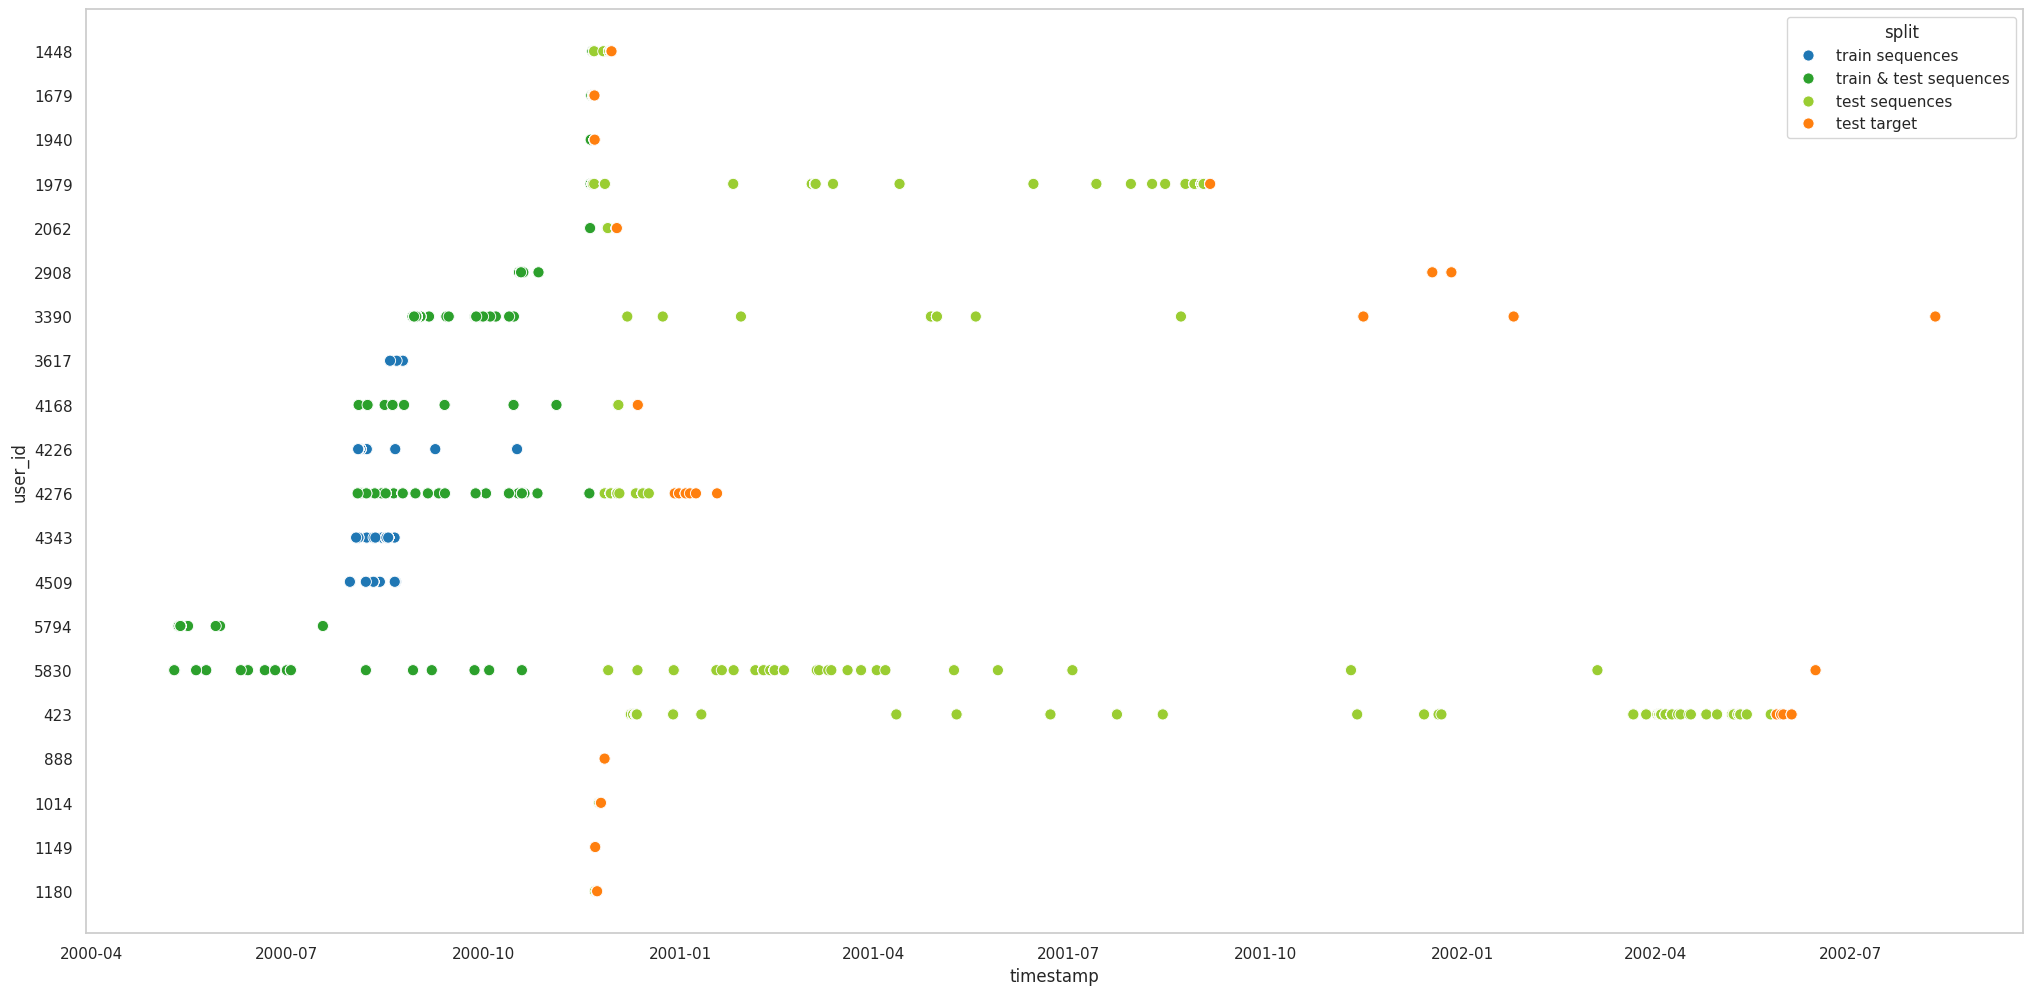

In [117]:
show_frames(
    [
        train,
        both_in_train_and_test,
        test_input,
        test_target,
    ],
    ["train sequences", "train & test sequences", "test sequences", "test target"],
)